# Dictionary Initialization

In [1]:
daily_log_likelihoods = {}
daily_regrets = {}

# collections for plotting charts about the performance of the EWMA predictor
betaValues = []
ewmaMeanRegretValues = []
ewmaMeanlogLikelihoodValues = []
prescientAlreadyPrinted = False

# Import Data

First date of training dataset:  2010-01-04 00:00:00
Last date of training dataset:  2019-02-08 00:00:00
len of training dataset:  2291

First date of validation dataset:  2019-02-11 00:00:00
Last date of validation dataset:  2021-09-14 00:00:00
len of validation dataset:  654

First date of test dataset:  2021-09-15 00:00:00
Last date of test dataset:  2022-12-30 00:00:00
len of test dataset:  327

total dataset lenght:  3272
sum of the three datasets:  3272
original returns dataframe dimension: (3272, 3)


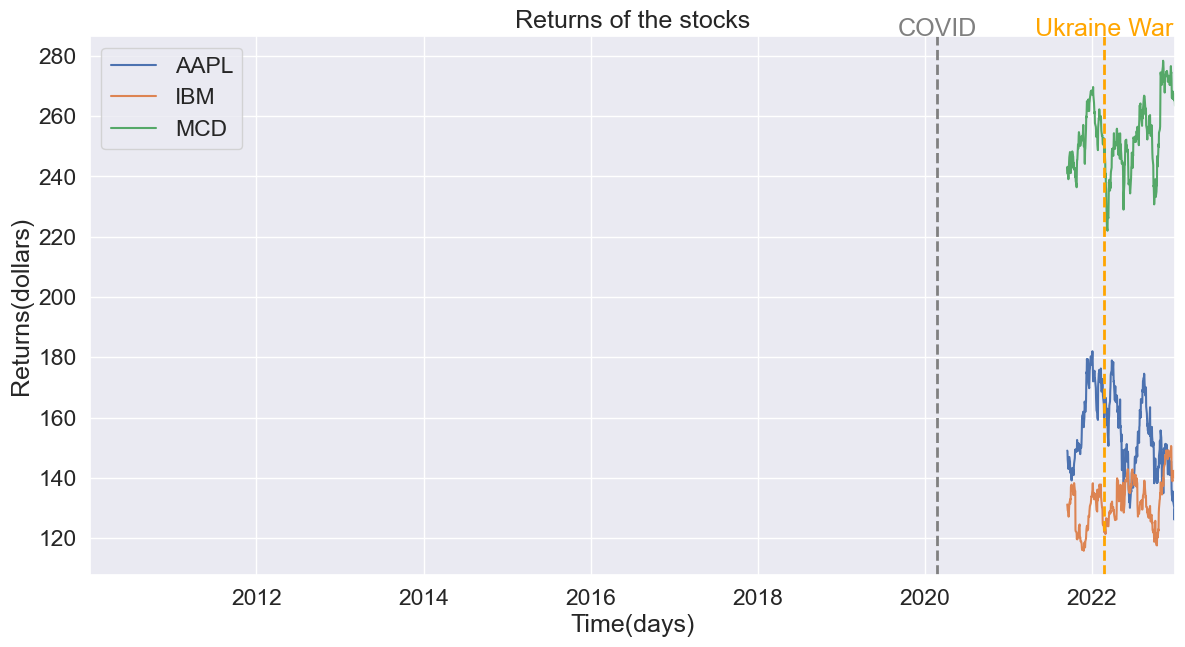

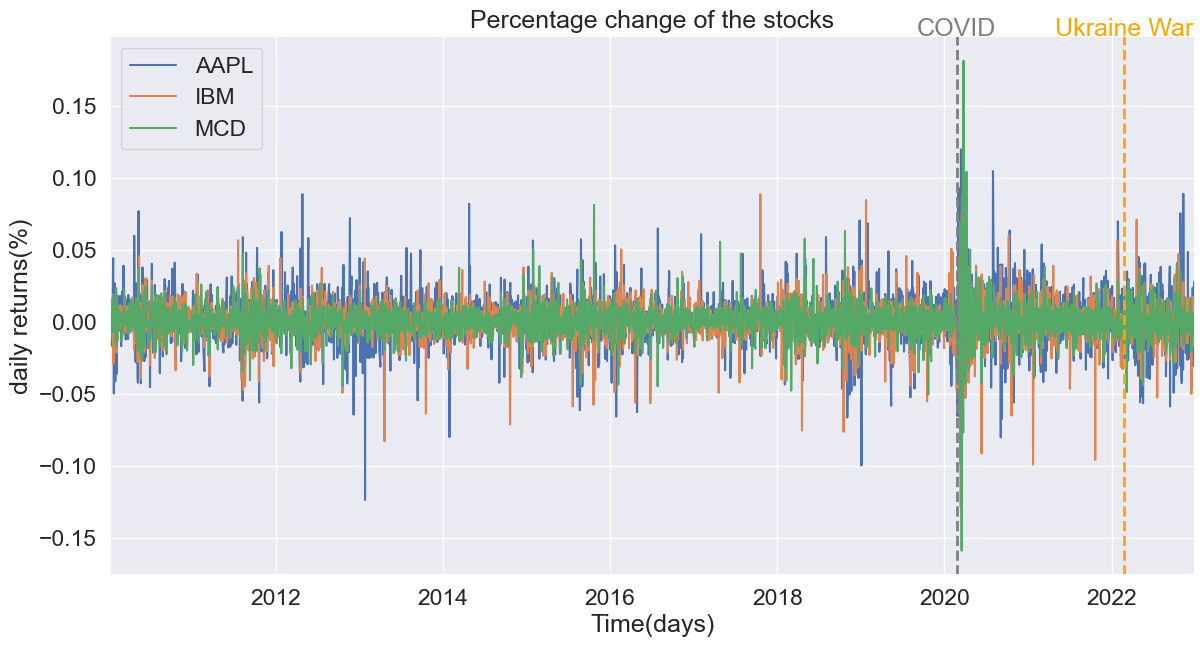

2010-01-04 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
2010-01-05 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
2010-01-06 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
2010-01-07 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
2010-01-08 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
dimension of the prescient dictionary: 3272
2010-01-04 00:00:00
          7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0

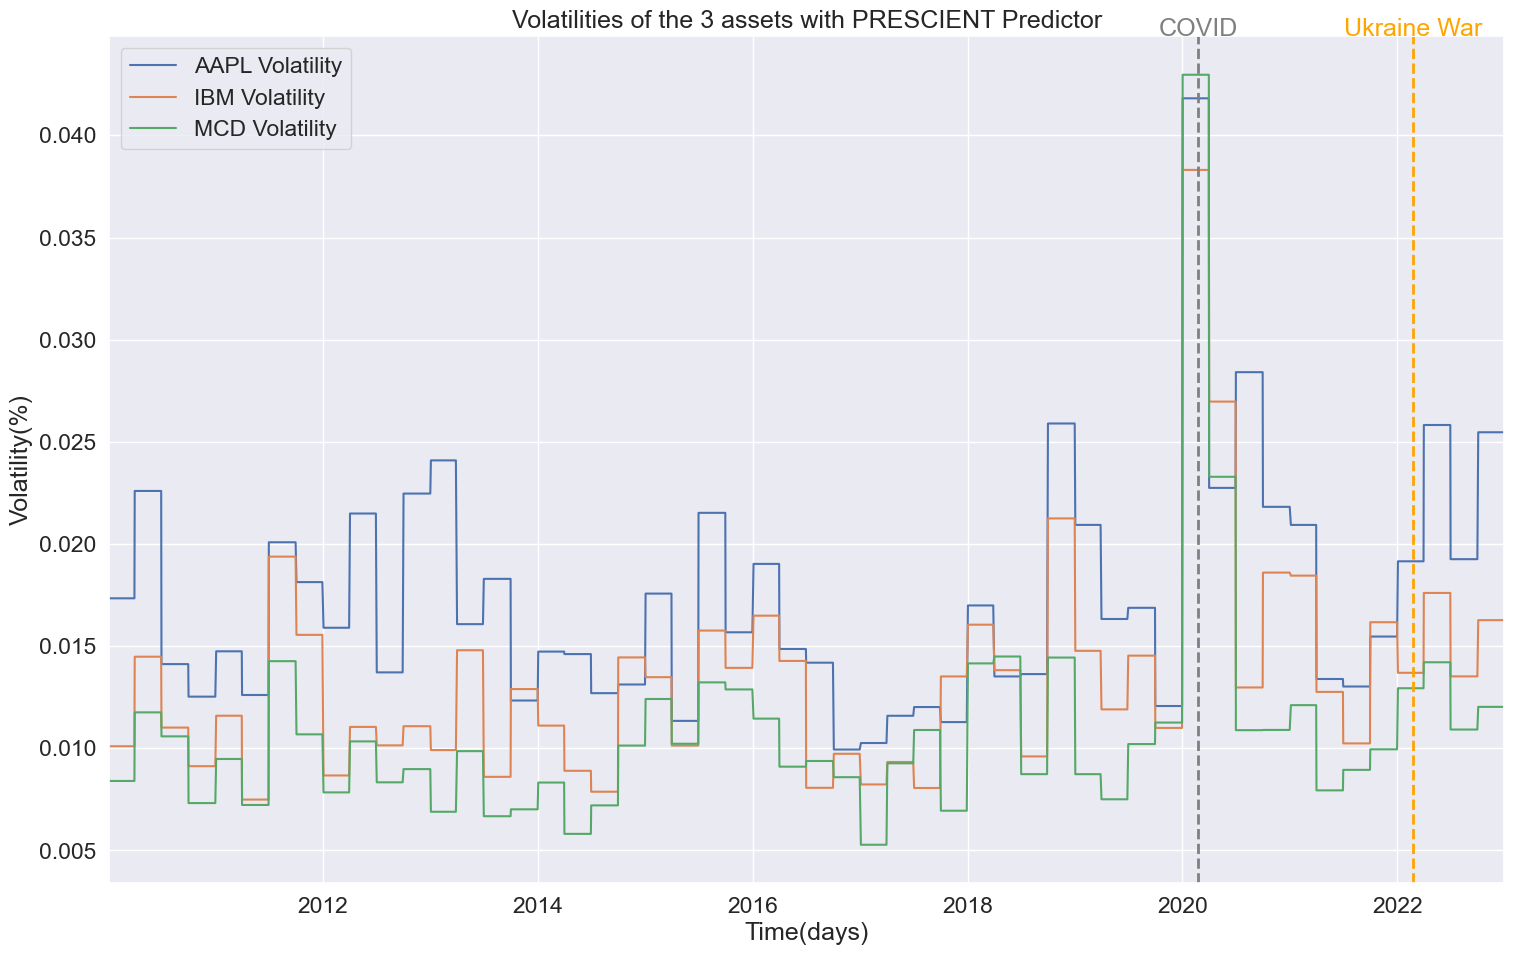

In [2]:
from cvx.covariance.ewma import iterated_ewma, _ewma_cov, _ewma_mean
from cvx.covariance.combination import from_sigmas

from predictorStarter import * # this file contains the import of every dataset, libraries needed and the initial plotting of the data
from predictorsImplementation import * # this file contains the implementation of the predictors ( one function implementation for each predictor)
from performanceMeasurement import * # this file contains the implementation of the performance measurement functions(like rmse, loglikelihood, regret, etc)

# Covariance Predictors(EWMA)

FOR THE EWMA PREDICTOR THERE IS NO TRAINING PHASE, THE PREDICTOR HAS BETA AS UNIQUE PARAMETER AND IT IS AN HYPERPARAMETER (0 < BETA < 1). 
The best value for beta has been found with the grid search method applied in the validation phase.

# Validation Phase for EWMA predictor

In [3]:
# Loop through beta values
# ewma_halflife = 100
# beta = 2 ** (-1 / ewma_halflife)
# beta = 0.1

def ewmaValidationPhase(betaValue, startingDate, endingDate, betaIncrement, prescientAlreadyPrinted):
    '''
    this function is used to perform the validation phase of the EWMA predictor; it's used to find the best beta value for the EWMA predictor.
    Grid search is used and the performance of the beta hyperparameter is evaluated using the MSE, log-likelihood and regret metrics.
    '''

    while betaValue < 1:

        ewma_halflife = -np.log(2) / np.log(betaValue)
        ewmaDict = dict(_ewma_cov(stocksPercentageChangeReturn, halflife=ewma_halflife))

        #
        # DEFINE END AND START DATES FOR BACKTESTS
        #
        
        start_date = pd.to_datetime(startingDate, format="%Y-%m-%d")
        end_date = pd.to_datetime(endingDate, format="%Y-%m-%d")

        names = ["EWMA", "PRESCIENT"]

        #these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
        predictors_temp = [ewmaDict, prescientDict]
        predictors = [] # so this is a list of dictionaries

        for predictor in predictors_temp:
            predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

        #
        # LOG-LIKELIHOODS
        #

        '''
            this dictionary has a shape like this:
            {
                RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
                PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
            }

            where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
        '''

        for i, predictorDict in enumerate(predictors):

            returns_temp = stocksPercentageChangeReturn.loc[pd.Series(predictorDict).index].values[1:]
            times = pd.Series(predictorDict).index[1:]
            Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
            daily_log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)


        #
        # REGRETS
        #

        for name in daily_log_likelihoods:
            daily_regrets[name] =  daily_log_likelihoods["PRESCIENT"] - daily_log_likelihoods[name]
            
        for name in daily_regrets:
            if name != "PRESCIENT":

                #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
                quarterly_regrets = daily_regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
                # so the regret variable is a series of average regret for each quarter
                
                regretMetrics = (np.mean(quarterly_regrets).round(1), np.std(quarterly_regrets).round(1), np.max(quarterly_regrets).round(1))
                # the round(1) function to each of these metrics, which rounds the result to one decimal place,

                # save the regret mean values to plot a chart
                ewmaMeanRegretValues.append(regretMetrics[0])


        # copy the log-likelihoods dictionary
        daily_log_likelihoods_copy = daily_log_likelihoods.copy()

        # do the same thing for log-likelihoods dictionary
        for name in daily_log_likelihoods_copy:
            quarterly_logLikelihood = daily_log_likelihoods_copy[name].resample("Q").mean()
            logLikelihoodMetrics = (np.mean(quarterly_logLikelihood).round(1), np.std(quarterly_logLikelihood).round(1), np.max(quarterly_logLikelihood).round(1))

            if name != "PRESCIENT":

                # save the loglikelihood mean values to plot a chart
                ewmaMeanlogLikelihoodValues.append(logLikelihoodMetrics[0])
                
            if name == "PRESCIENT" and prescientAlreadyPrinted == False:
                prescientAlreadyPrinted = True

                # save the loglikelihood mean value to plot a chart
                prescientMeanlogLikelihoodValue = logLikelihoodMetrics[0]

        # save every fundamental value to plot a chart 
        betaValues.append(betaValue)

        # Increment beta
        betaValue += betaIncrement

    print("lenght of ewmaDict: ", len(ewmaDict))
    print("first timestamp of ewmaDict: ", list(ewmaDict.keys())[0])
    print("last timestamp of ewmaDict: ", list(ewmaDict.keys())[-1])

    # return the fundamental values to plot a chart
    return betaValues, ewmaMeanRegretValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue

lenght of ewmaDict:  3272
first timestamp of ewmaDict:  2010-01-04 00:00:00
last timestamp of ewmaDict:  2022-12-30 00:00:00
beta: 0.9300
 Log-likelihood: 8.4000
beta: 0.9700
 Log-likelihood: 8.4000


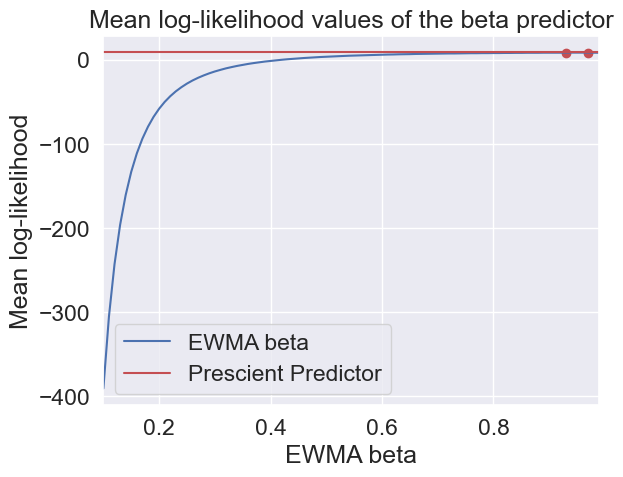

beta: 0.9300
 Regret: 0.2000
beta: 0.9700
 Regret: 0.2000


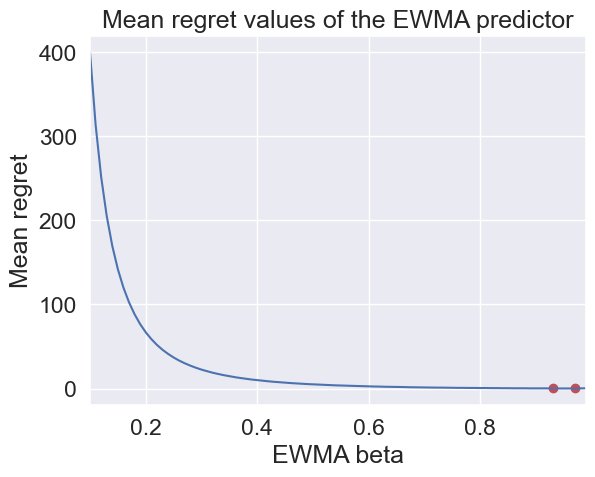

max_pointsX: [0.9300000000000007, 0.9700000000000008]
max_pointsY: [8.4, 8.4]
min_pointsX: [0.9300000000000007, 0.9700000000000008]
min_pointsY: [0.2, 0.2]


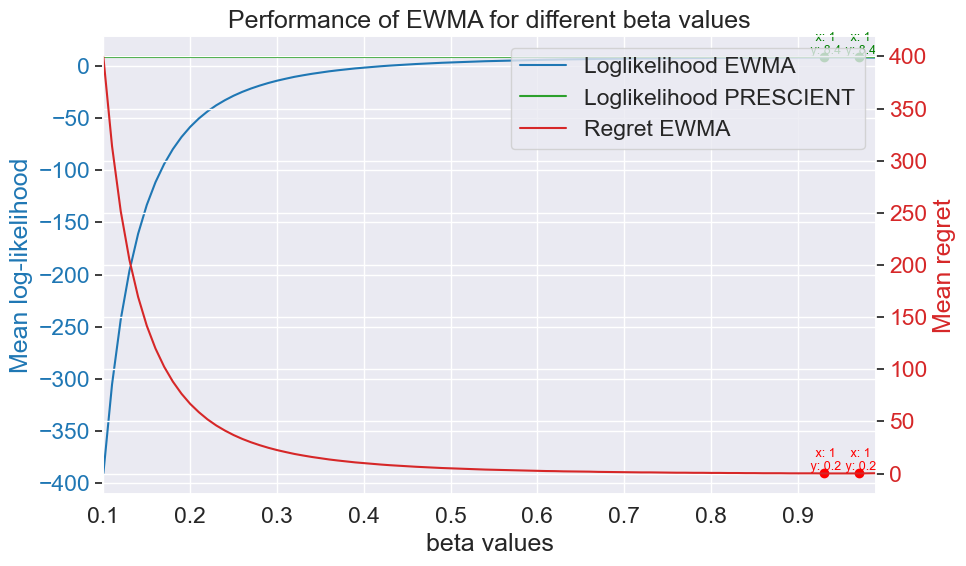

In [4]:
# first run for grid search -> this is a general run to cover the entire range of beta values
betaValues, ewmaMeanRegretValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue = ewmaValidationPhase(0.1, startingValidationDate, endingValidationDate, 0.01, prescientAlreadyPrinted)

# plot the performance of the EWMA predictor in terms of loglikelihood
plotLogLikelihoodPerformancePredictor(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, "EWMA", "beta")

# plot the performance of the EWMA predictor in terms of regret
plotRegretPerformancePredictor(betaValues, ewmaMeanRegretValues, "EWMA", "beta")

plotPerformancePredictor(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, ewmaMeanRegretValues, "EWMA", "beta")

From the chart is evident that the model has the best performance with 0.9 < beta < 1; so now i will do the zoom in this range

lenght of ewmaDict:  3272
first timestamp of ewmaDict:  2010-01-04 00:00:00
last timestamp of ewmaDict:  2022-12-30 00:00:00
beta: 0.9250
 Log-likelihood: 8.4000
beta: 0.9760
 Log-likelihood: 8.4000


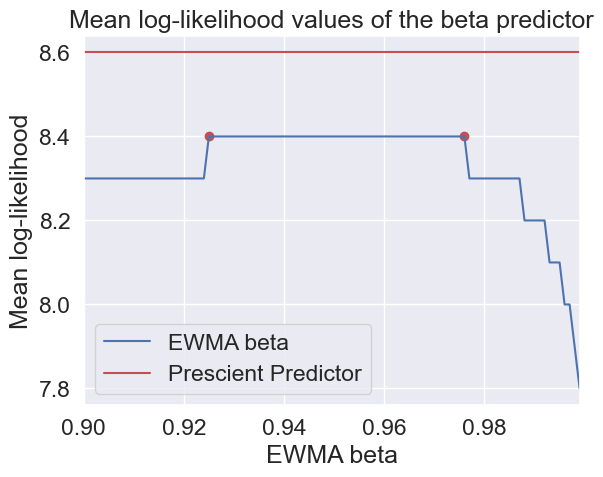

beta: 0.9280
 Regret: 0.2000
beta: 0.9750
 Regret: 0.2000


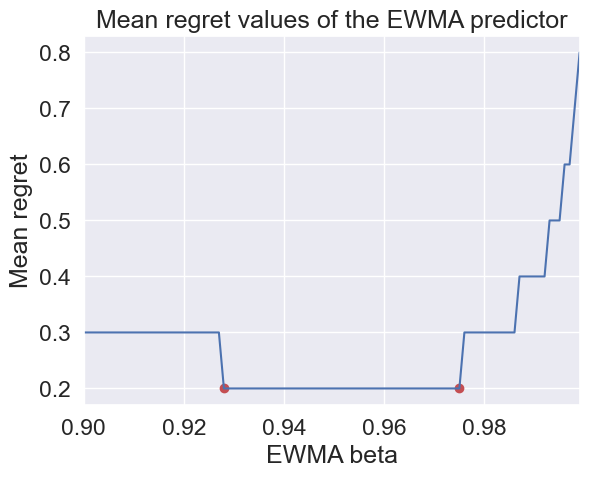

max_pointsX: [0.925, 0.9760000000000001]
max_pointsY: [8.4, 8.4]
min_pointsX: [0.928, 0.9750000000000001]
min_pointsY: [0.2, 0.2]


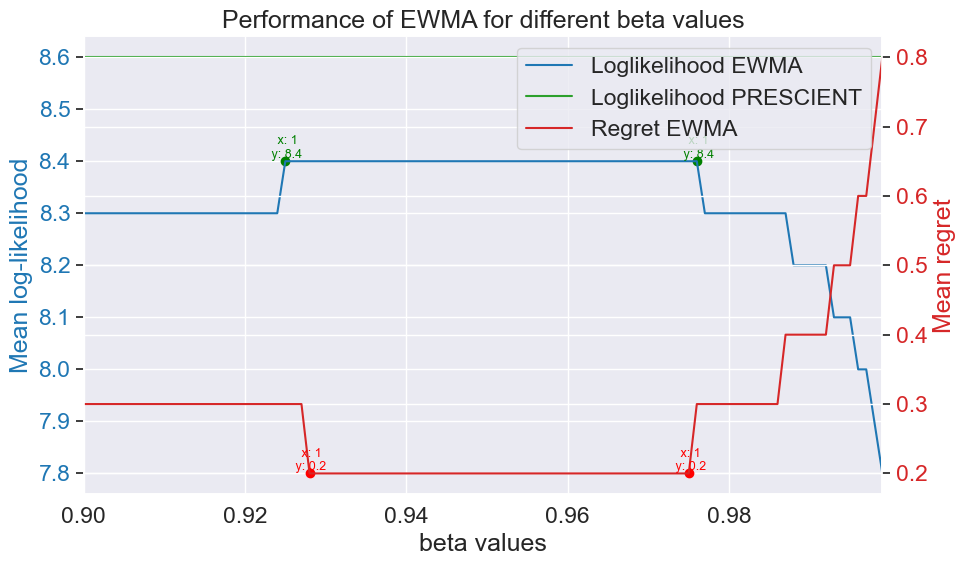

In [5]:
# to go faster i skip the validation part(the correct memoru value parameter has been already found)

# clear the lists to make another run of the grid search
betaValues.clear()
ewmaMeanRegretValues.clear()
ewmaMeanlogLikelihoodValues.clear()
prescientMeanlogLikelihoodValue = 0

# this is a specific run to find the best beta value (i will search in the range 0.9 -> 1 with a step of 0.001)
betaValues, ewmaMeanRegretValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue = ewmaValidationPhase(0.9, startingValidationDate, endingValidationDate, 0.001, prescientAlreadyPrinted)

# plot the performance of the EWMA predictor in terms of loglikelihood
plotLogLikelihoodPerformancePredictor(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, "EWMA", "beta")

# plot the performance of the EWMA predictor in terms of regret
plotRegretPerformancePredictor(betaValues, ewmaMeanRegretValues, "EWMA", "beta")

plotPerformancePredictor(betaValues, ewmaMeanlogLikelihoodValues, prescientMeanlogLikelihoodValue, ewmaMeanRegretValues, "EWMA", "beta")

In [6]:
'''
# print the log likelihood value and regret value for beta = 0.97
Beta = 0.9870000000000001
ewma_halflife = -np.log(2) / np.log(Beta)

print("betavalues: " + str(betaValues))

print("beta: " + str(Beta))
print("ewma_halflife: " + str(ewma_halflife))
print("log likelihood: " + str(ewmaMeanlogLikelihoodValues[betaValues.index(Beta)]))
print("regret: " + str(ewmaMeanRegretValues[betaValues.index(Beta)]))
'''

'\n# print the log likelihood value and regret value for beta = 0.97\nBeta = 0.9870000000000001\newma_halflife = -np.log(2) / np.log(Beta)\n\nprint("betavalues: " + str(betaValues))\n\nprint("beta: " + str(Beta))\nprint("ewma_halflife: " + str(ewma_halflife))\nprint("log likelihood: " + str(ewmaMeanlogLikelihoodValues[betaValues.index(Beta)]))\nprint("regret: " + str(ewmaMeanRegretValues[betaValues.index(Beta)]))\n'

In [7]:
'''
# example of behaviour with a bad beta value
prescientAlreadyPrinted = False

# select the best beta value for the EWMA predictor (the one found in the previous step)
beta = 0.1

ewma_halflife = -np.log(2) / np.log(beta)

# now i will use the best beta value to perform the test phase

# now i want to print the repective value of beta: the beta is the value of the decay factor used in the ewma formula
print("ewma_halflife used: " + str(ewma_halflife) + "\n")

# ewma is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper
# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day
ewmaDict = dict(_ewma_cov(validationDataWithPercentageChange, ewma_halflife))

# now filter the ewma volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingvalidationDate)
real_volatility_endDate = pd.to_datetime(endingvalidationDate)

df_ewma_volatility_aapl, df_ewma_volatility_ibm, df_ewma_volatility_mcd, ewma_volatility_dict_aapl, ewma_volatility_dict_ibm, ewma_volatility_dict_mcd = plot_volatility(ewmaDict, real_volatility_startDate, real_volatility_endDate, 'EWMA')
'''

'\n# example of behaviour with a bad beta value\nprescientAlreadyPrinted = False\n\n# select the best beta value for the EWMA predictor (the one found in the previous step)\nbeta = 0.1\n\newma_halflife = -np.log(2) / np.log(beta)\n\n# now i will use the best beta value to perform the test phase\n\n# now i want to print the repective value of beta: the beta is the value of the decay factor used in the ewma formula\nprint("ewma_halflife used: " + str(ewma_halflife) + "\n")\n\n# ewma is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper\n# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day\newmaDict = dict(_ewma_cov(validationDataWithPercentageChange, ewma_halflife))\n\n# now filter the ewma volatilities between the start and end date\nreal_volatility_startDate = pd.to_datetime(startingvalidationDate)\nreal_volatility_endDate = pd.to_datetime(endingvalidationDate)\n\ndf_ewma_vol

In [8]:
'''
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = validationDataWithPrices.index[0]
endDateFilter = validationDataWithPrices.index[-1]

plot_prices_volatilities_for_ewma(validationDataWithPrices, df_volatility_aapl['AAPL Volatility'], startDateFilter, endDateFilter, df_ewma_volatility_aapl['AAPL Volatility'], 'AAPL')
'''

"\n# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY\nstartDateFilter = validationDataWithPrices.index[0]\nendDateFilter = validationDataWithPrices.index[-1]\n\nplot_prices_volatilities_for_ewma(validationDataWithPrices, df_volatility_aapl['AAPL Volatility'], startDateFilter, endDateFilter, df_ewma_volatility_aapl['AAPL Volatility'], 'AAPL')\n"

# Test Phase for EWMA predictor

In this test phase i will use the best value for beta found in the validation phase to see the performance of the model on the test set and i will plot some charts to compare the volatility predicted by the model with the ground truth.

ewma_halflife used: 13.513407333964874



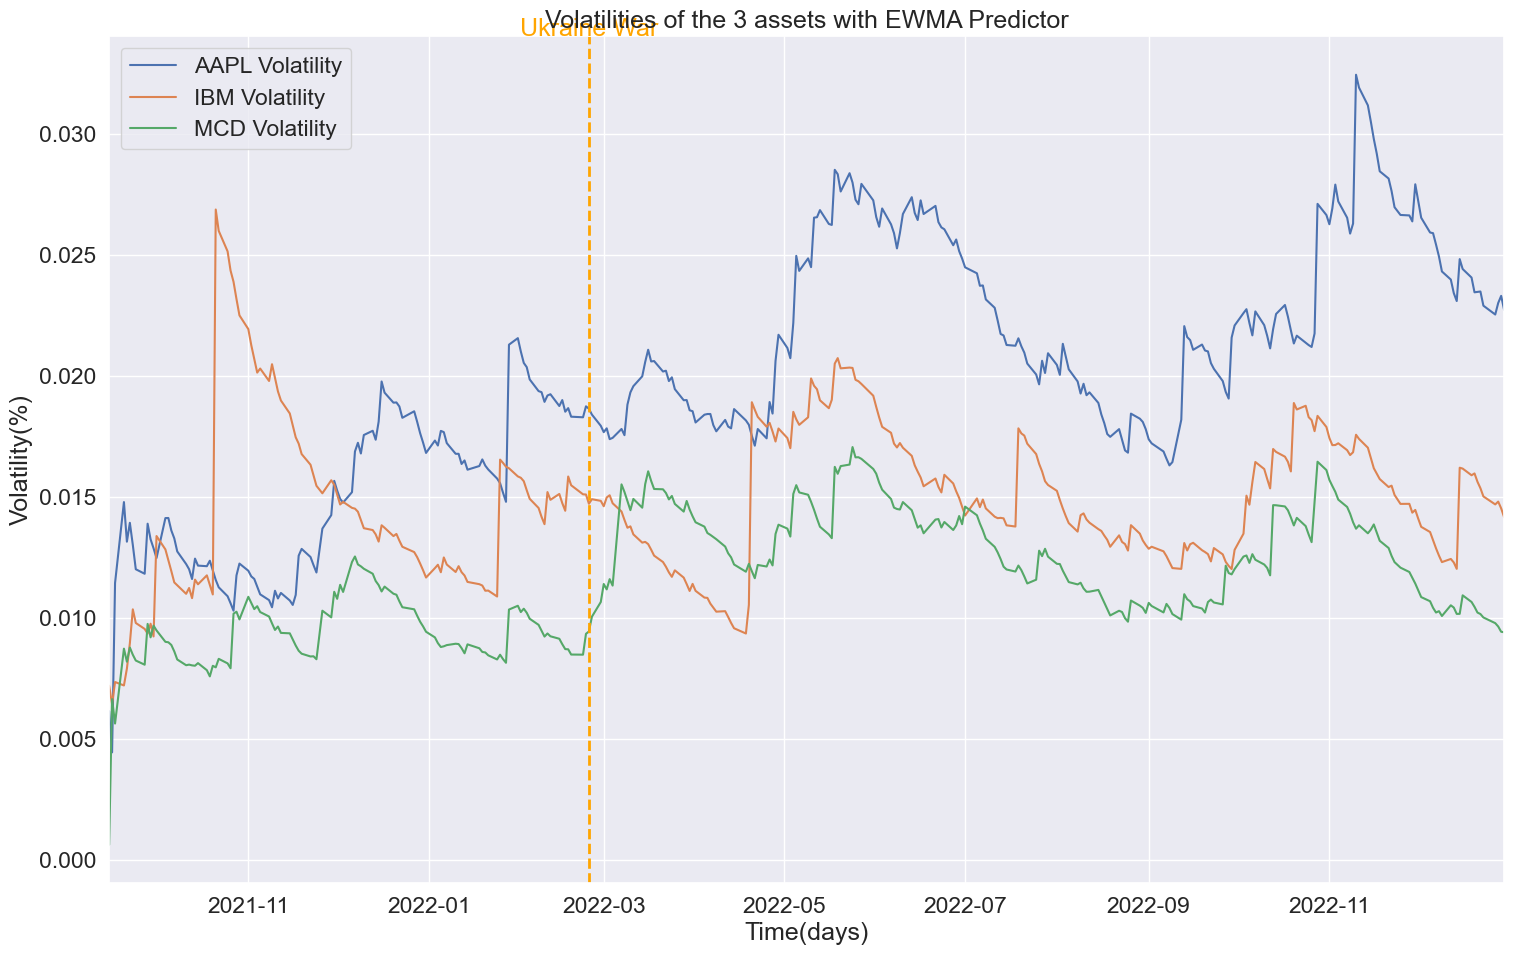

In [9]:
# prepare the date for the test phase
prescientAlreadyPrinted = False

# select the best beta value for the EWMA predictor (the one found in the previous step)
beta = predictorsConfiguration["EWMA_beta"]
ewma_halflife = -np.log(2) / np.log(beta)

# now i will use the best beta value to perform the test phase

# now i want to print the repective value of beta: the beta is the value of the decay factor used in the ewma formula
print("ewma_halflife used: " + str(ewma_halflife) + "\n")

# ewma is a dictionary that contains the covariance matrix calculated using the ewma formula written inside the paper
# the key of the dictionary is the timestamp and the value is the covariance matrix calculated for that day
ewmaDict = dict(_ewma_cov(testDataWithPercentageChange, ewma_halflife))

# now filter the ewma volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingTestDate)
real_volatility_endDate = pd.to_datetime(endingTestDate)

df_ewma_volatility_aapl, df_ewma_volatility_ibm, df_ewma_volatility_mcd, ewma_volatility_dict_aapl, ewma_volatility_dict_ibm, ewma_volatility_dict_mcd = plot_volatility(ewmaDict, real_volatility_startDate, real_volatility_endDate, 'EWMA')

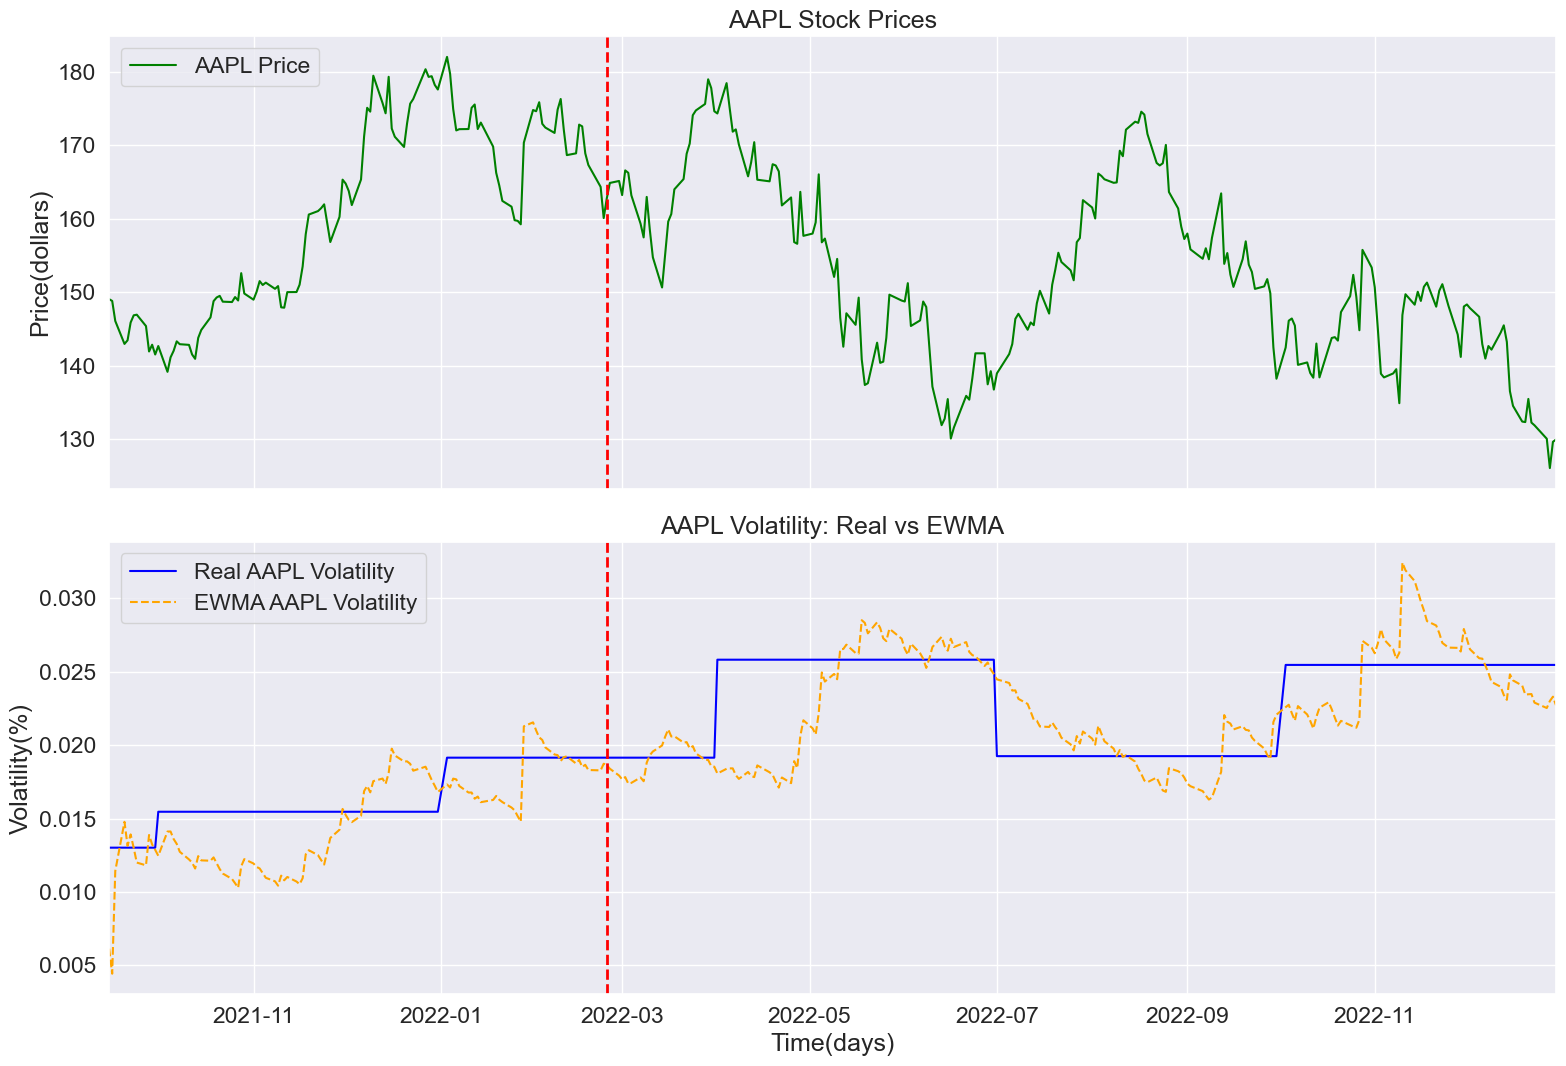

In [10]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_aapl['AAPL Volatility'], startDateFilter, endDateFilter, df_ewma_volatility_aapl['AAPL Volatility'], 'AAPL', "EWMA")

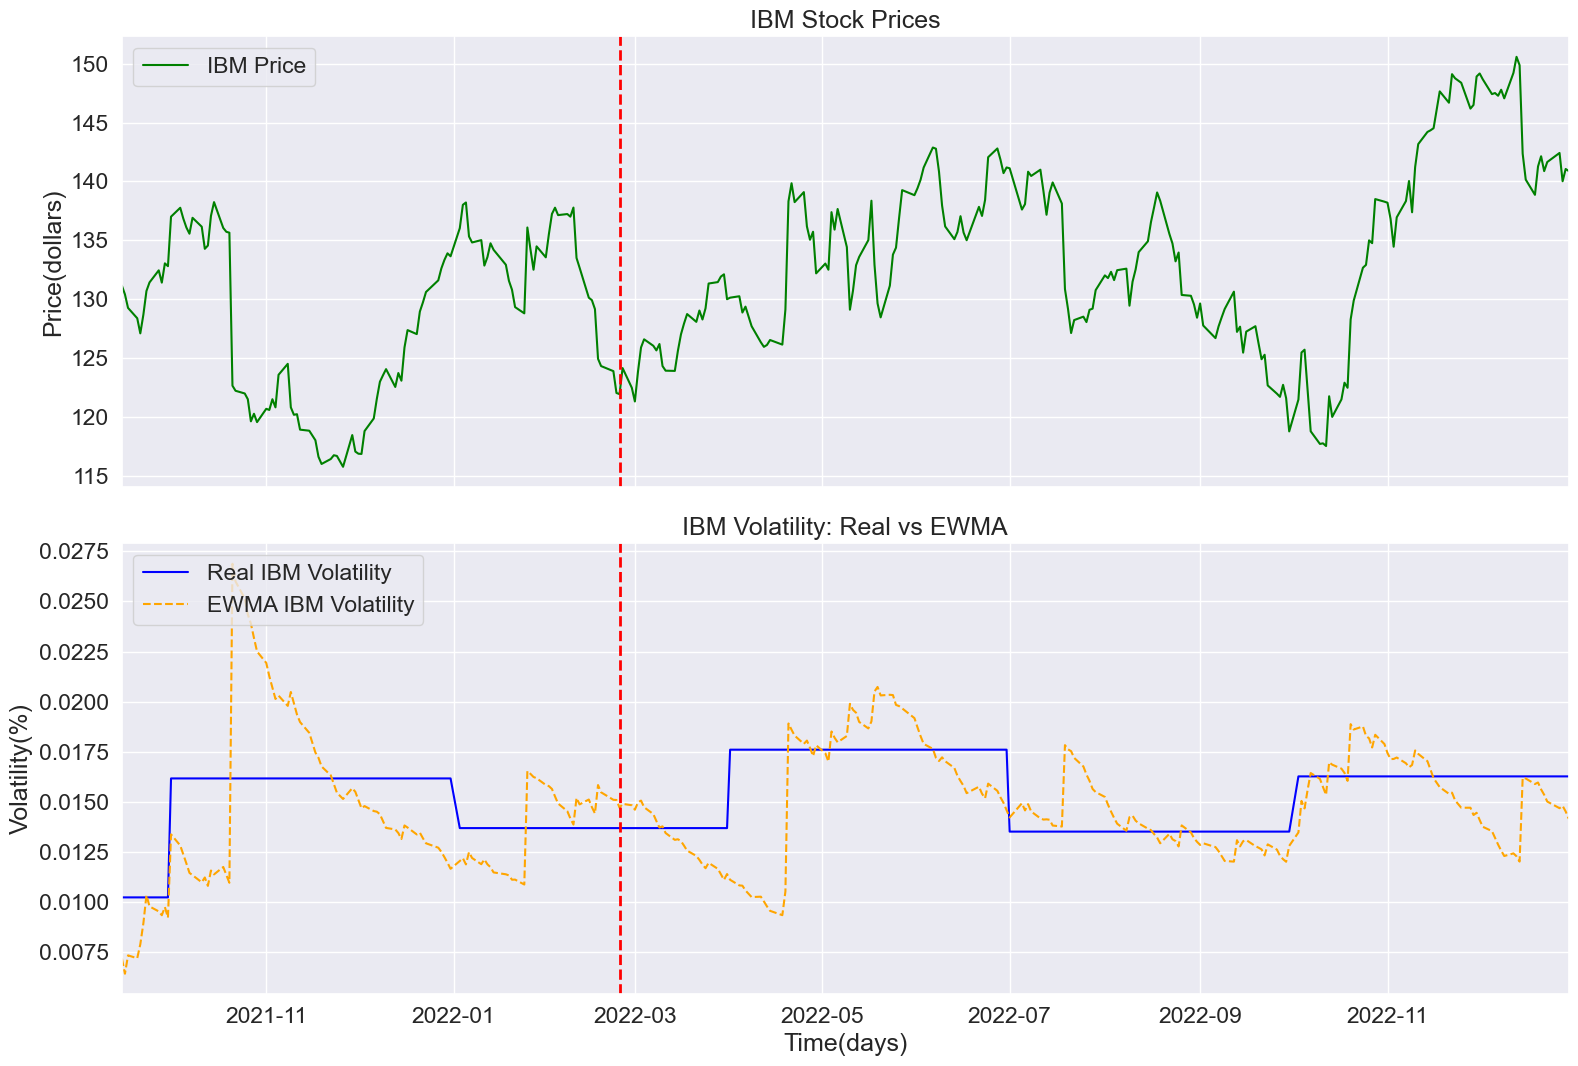

In [11]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_ibm['IBM Volatility'], startDateFilter, endDateFilter, df_ewma_volatility_ibm['IBM Volatility'], 'IBM', "EWMA")

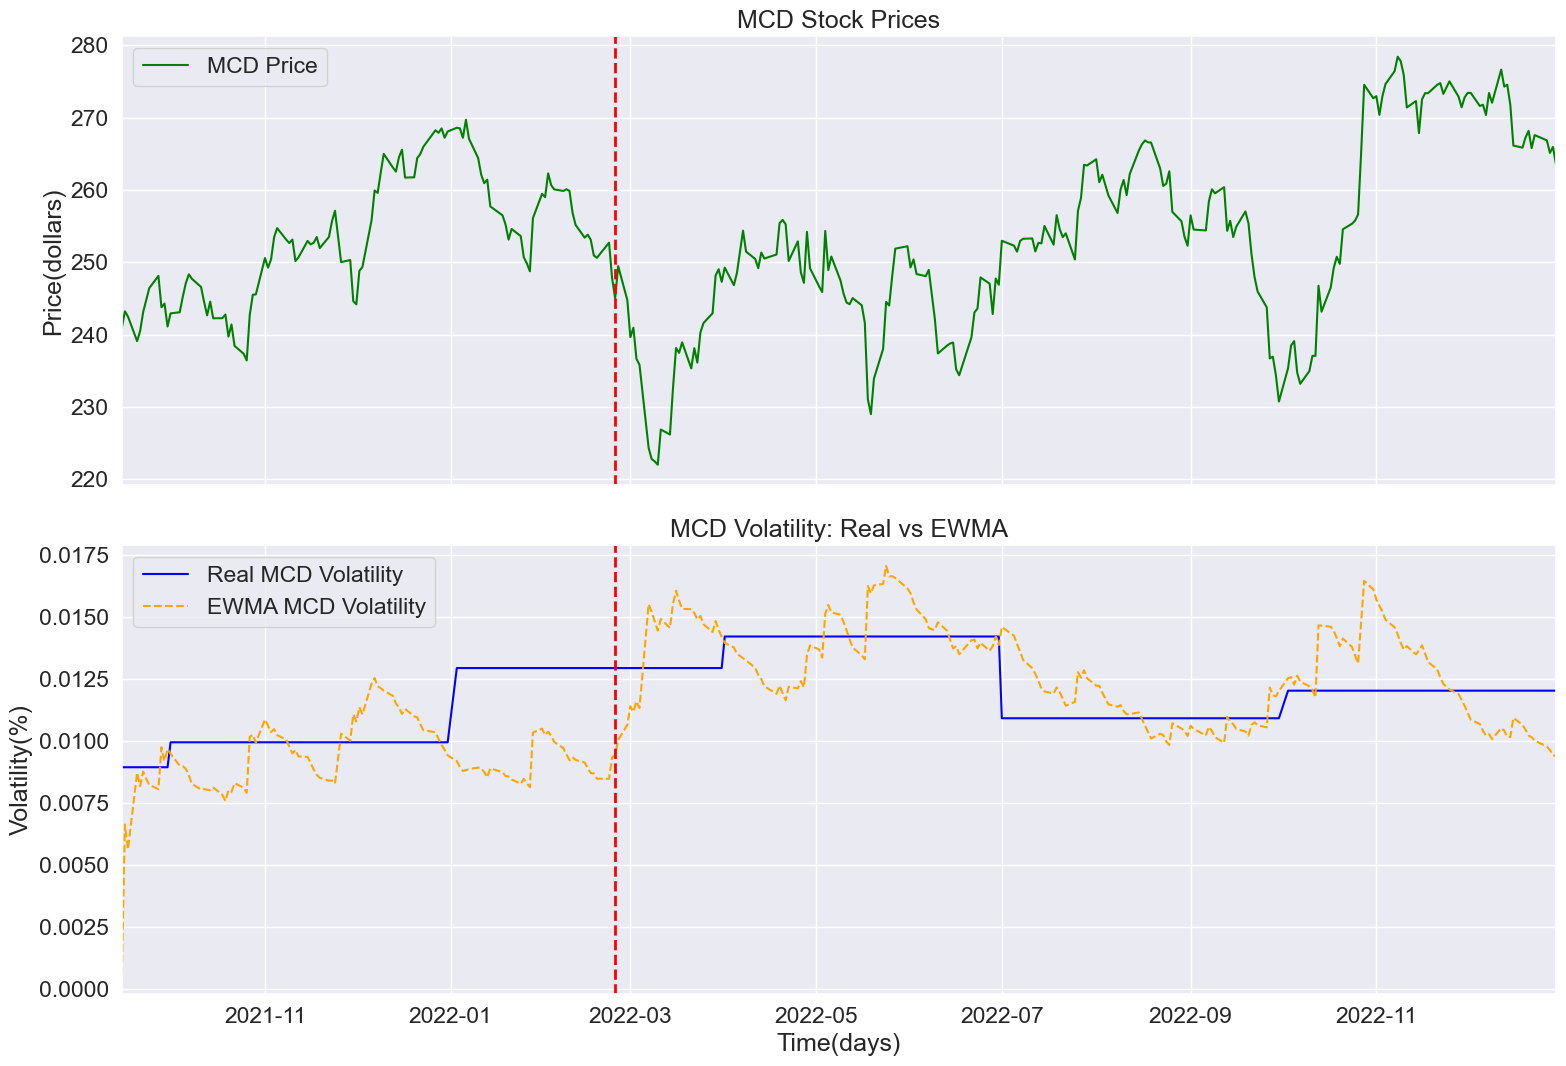

In [12]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_mcd['MCD Volatility'], startDateFilter, endDateFilter, df_ewma_volatility_mcd['MCD Volatility'], 'MCD', "EWMA")

size of the first predictor: 308
size of the second predictor: 308
first timestamp of the first predictor: 2021-10-12 00:00:00
first timestamp of the second predictor: 2021-10-12 00:00:00


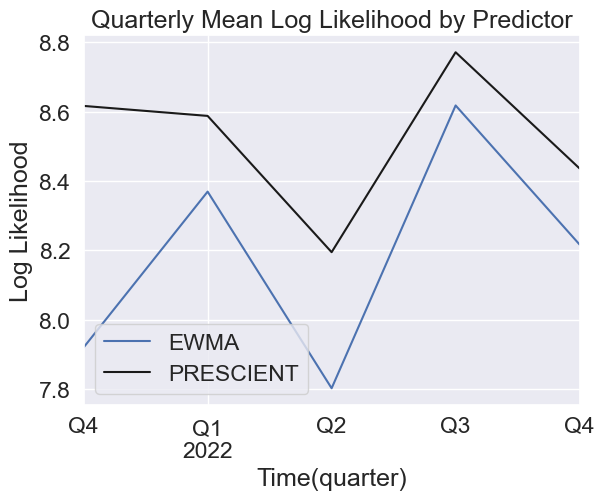

logLikelihood length:  5
logLikelihood shape:  (5,)


meanLoglikelihoodEWMA: 8.200
stdLoglikelihoodEWMA: 0.300
maxLoglikelihoodEWMA: 8.600
logLikelihood length:  5
logLikelihood shape:  (5,)


meanLoglikelihoodPRESCIENT: 8.500
stdLoglikelihoodPRESCIENT: 0.200
maxLoglikelihoodPRESCIENT: 8.800


meanRegret: 0.300
stdRegret: 0.200
maxRegret: 0.700
lenght of prescientDict:  3272
lenght of ewmaDict:  327
lenght of predictorDict:  308

EWMA RMSE
mean: 0.0138895248
std: 0.0017768174
max: 0.0169567752
lenght of rmses:  5
values of rmses:  {Timestamp('2022-01-02 00:00:00'): 0.013473559901956825, Timestamp('2022-03-31 00:00:00'): 0.012433935472057813, Timestamp('2022-06-30 00:00:00'): 0.016956775216509245, Timestamp('2022-10-02 00:00:00'): 0.011993454142127704, Timestamp('2022-12-29 00:00:00'): 0.01458989928367914}


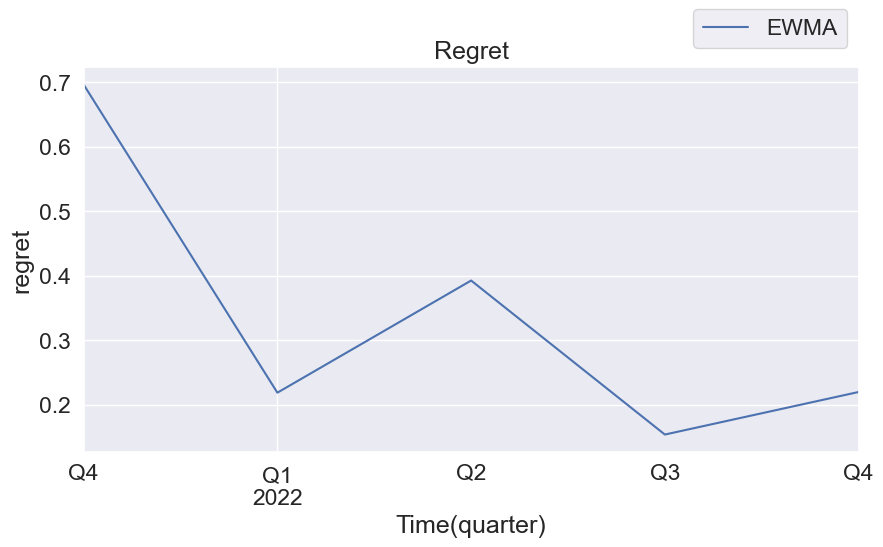

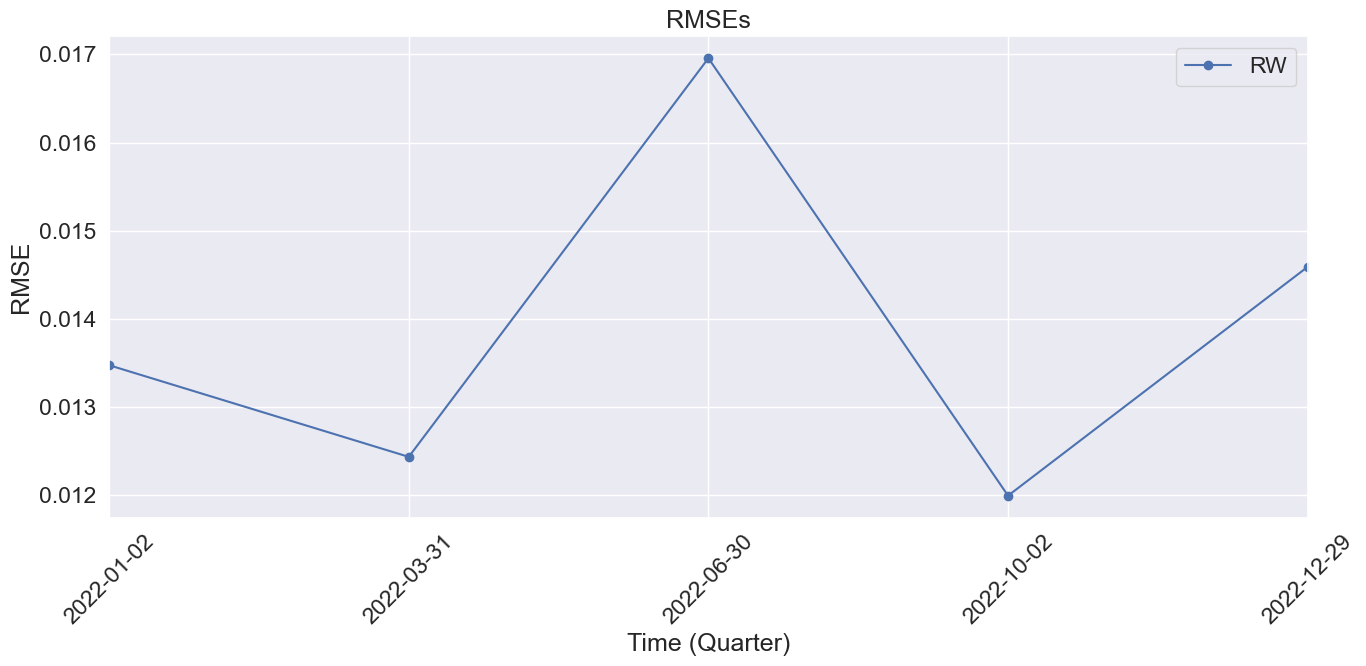

lenght of volatility_dict_aapl:  308
lenght of volatility_dict_aaapl_ewma:  308
lenght of RMSEs_aapl:  5
values of RMSEs_aapl:  {Timestamp('2022-01-02 00:00:00'): 0.00317422904160878, Timestamp('2022-03-31 00:00:00'): 0.001770428591044339, Timestamp('2022-06-30 00:00:00'): 0.004501733008227381, Timestamp('2022-10-02 00:00:00'): 0.002152449558819214, Timestamp('2022-12-29 00:00:00'): 0.0029257045639822813}


RMSEs for AAPL
mean: 0.0029049090
std: 0.0009461558
max: 0.0045017330


RMSEs for IBM
mean: 0.0025055011
std: 0.0010635506
max: 0.0040237745


RMSEs for MCD
mean: 0.0018173996
std: 0.0007837247
max: 0.0032975534
Stored 'ewmaDictFiltered' (dict)


In [13]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE EWMA PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["EWMA", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [ewmaDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})


ewmaDictionary = predictors[0]
ewmaDictionary = {k: ewmaDictionary[k] for k in list(ewmaDictionary)[19:]}
predictors[0] = ewmaDictionary

# now remove the first 19 entries from the predictor 1(prescient dict)
prescientDictionary = predictors[1]

# now remove the first 19 entries from the prescient dict
prescientDictionary = {k: prescientDictionary[k] for k in list(prescientDictionary)[19:]}
predictors[1] = prescientDictionary

print("size of the first predictor: " + str(len(predictors[0])))
print("size of the second predictor: " + str(len(predictors[1])))


# make an assert to check if the length of the two predictors is the same
assert len(predictors[0]) == len(predictors[1])

# make an assert to check if the timestamps of the two predictors are the same
assert predictors[0].keys() == predictors[1].keys()

# print the first timestamp of the two predictors
print("first timestamp of the first predictor: " + str(list(predictors[0].keys())[0]))
print("first timestamp of the second predictor: " + str(list(predictors[1].keys())[0]))

# if we are here, it means that the two predictors have the same length and the same timestamps so i can measure the performance of the two predictors


#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        ewma: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

daily_log_likelihoods = predictorLogLikelihood(stocksPercentageChangeReturn, predictors, names)

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        ewma: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
predictorRegret(daily_log_likelihoods, names)

#
# RMSEs
#

print("lenght of prescientDict: ", len(prescientDict))
print("lenght of ewmaDict: ", len(ewmaDict))
        
RMSEcovarianceMatrix(testDataWithPercentageChange, predictors, prescientDict, start_date, names)

#
# RMSEs for single assets
#
        
# take the first timestamp contained in prescientDict and use it as the start date
startDAte = list(prescientDictionary.keys())[0]

# filter every volatility dictionary to get only the values that are greater than or equal to the start date
volatility_dict_aapl_filtered = {k: v for k, v in volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_filtered = {k: v for k, v in volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_filtered = {k: v for k, v in volatility_dict_mcd.items() if k >= startDAte}

volatility_dict_aapl_ewma_filtered = {k: v for k, v in ewma_volatility_dict_aapl.items() if k >= startDAte}
volatility_dict_ibm_ewma_filtered = {k: v for k, v in ewma_volatility_dict_ibm.items() if k >= startDAte}
volatility_dict_mcd_ewma_filtered = {k: v for k, v in ewma_volatility_dict_mcd.items() if k >= startDAte}


print("lenght of volatility_dict_aapl: ", len(volatility_dict_aapl_filtered))
print("lenght of volatility_dict_aaapl_ewma: ", len(volatility_dict_aapl_ewma_filtered))

# get the rmse of single assets. i take just aapl, ibm and mcd
RMSEforSingleAssets(testDataWithPercentageChange, volatility_dict_aapl_filtered, volatility_dict_ibm_filtered, volatility_dict_mcd_filtered, volatility_dict_aapl_ewma_filtered, volatility_dict_ibm_ewma_filtered, volatility_dict_mcd_ewma_filtered, start_date)

# store the covariance matrixes dict of the filtered dataset
ewmaDictFiltered = predictors[0]

%store ewmaDictFiltered

Now here i store all the variables that i need to pass to other notebooks.

In [14]:
# create a dictionary for the volatilities of the rw predictor
ewma_volatilities = {}

# add the volatilities of the 3 assets to the dictionary
ewma_volatilities["AAPL"] = volatility_dict_aapl_ewma_filtered
ewma_volatilities["IBM"] = volatility_dict_ibm_ewma_filtered
ewma_volatilities["MCD"] = volatility_dict_mcd_ewma_filtered

# store the dictionary
%store ewma_volatilities


Stored 'ewma_volatilities' (dict)
